<a href="https://colab.research.google.com/github/KonstantinElfimow/E-Commerce-Analysis/blob/main/e_commerce_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Сделать RFM-анализ https://www.kaggle.com/datasets/carrie1/ecommerce-data. Выявить лояльность пользователей. Посчитать продуктовые метрики.

In [1]:
! gdown 1YpyajgsyZM07df7ibglOx5gjjqzwcE0P

Downloading...
From: https://drive.google.com/uc?id=1YpyajgsyZM07df7ibglOx5gjjqzwcE0P
To: /content/archive.zip
100% 7.55M/7.55M [00:00<00:00, 42.4MB/s]


In [2]:
! unzip '/content/archive.zip'

Archive:  /content/archive.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 1. Исследование данных на качество и предобработка

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib.ticker import MultipleLocator

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

In [4]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1', skipinitialspace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Переведу CustomerID к int, InvoiceDate - к timestamp

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [6]:
# напишем функцию первичной проверки данных
def check_data(data_df):
  '''Функция для вывода общих сведений о датафрейме'''
  print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
  print(data_df.info())
  # проверим nan
  print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
  print('Количество пропусков:\n{:.0f}'.format(data_df.isnull().sum().sum()))
  print('Доля пропусков:\n{}'.format(data_df.isna().mean()))
  plt.figure(figsize=(10, 6))
  sns.heatmap(df.sample(int(len(data_df) * 0.01)).isna().T);
  plt.suptitle('Оценка пропусков на heatmap')
  plt.show()
  print()
  # проверим дубликаты
  print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
  print('Количество полных дубликатов:\n', data_df.duplicated().sum())
  # посмотрим на сами данные
  print('\033[1m' + '\nПервые 10 строк датасета' + '\033[0m')
  display(data_df.head(10))

  print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
  display(data_df.describe(exclude=['object', 'category']).T)
  print('\033[1m' + '\nГрафическое представление количественных данных:' + '\033[0m')
  for numeric_column in data_df.select_dtypes(exclude=['object', 'category']).columns:
    sns.kdeplot(data=df, x=numeric_column)
    plt.xlabel(numeric_column)
    plt.ylabel('Плотность вероятности')
    plt.suptitle(f'Распределение ({numeric_column})')
    plt.show()
    print()

  print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
  display(data_df.describe(include=['object', 'category']).T)
  print('\033[1m' + '\nГрафическое представление категориальных данных:' + '\033[0m')

  sns.barplot(data_df['Country'].value_counts().sort_values(ascending=False)[:7])
  # table.columns = ['col1', 'count']
  # plt.pie(table['count'], labels=table['col1'], autopct='%1.1f%%')
  plt.suptitle(f'Частота Country')
  plt.xticks(rotation=45)
  plt.show()
  print()

  print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
  display(data_df.describe(include=['object']).T)

  print('\033[1m' + '\nВывод уникальных значений'\
  ' по каждому признаку:' + '\033[0m')

  for i in data_df.columns:
    print('\033[1m' + str(i) + '\033[0m')
    display(data_df[i].value_counts().sort_values())

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Проверка пропусков
Количество пропусков:
136534
Доля пропусков:
InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64


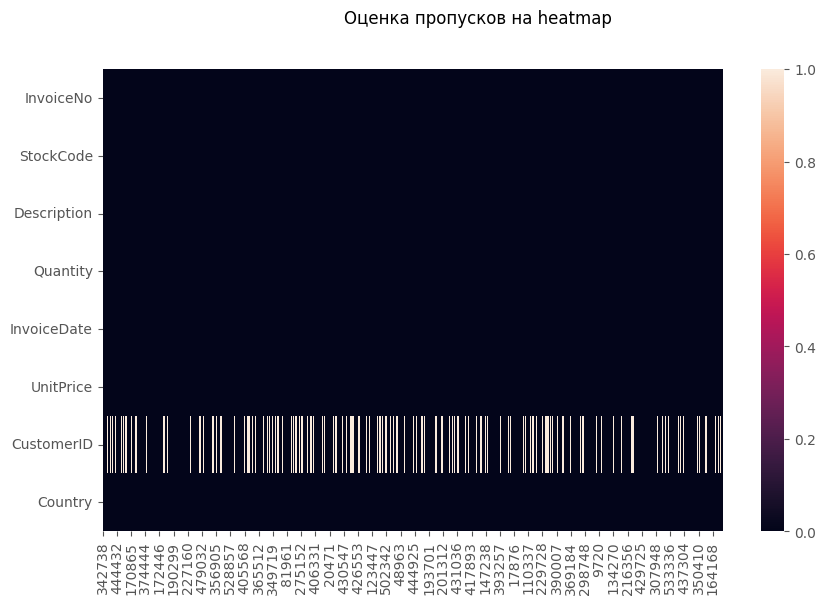



Проверка на дубликаты
Количество полных дубликатов:
 5268

Первые 10 строк датасета


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom



Описание количественных данных:


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Quantity,541909.0,NaN,NaT,NaN,NaT,NaT,9.55225,218.081158,-80995.0,1.0,3.0,10.0,80995.0
InvoiceDate,541909,23260,2011-10-31 14:41:00,1114,2010-12-01 08:26:00,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909.0,NaN,NaT,NaN,NaT,NaT,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,NaN,NaT,NaN,NaT,NaT,15287.69057,1713.600303,12346.0,13953.0,15152.0,16791.0,18287.0



Графическое представление количественных данных:


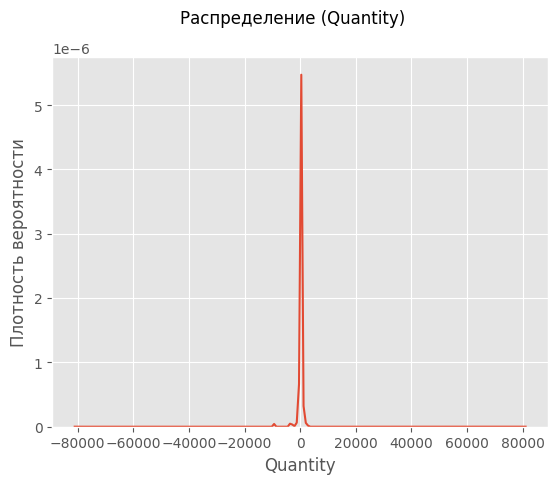

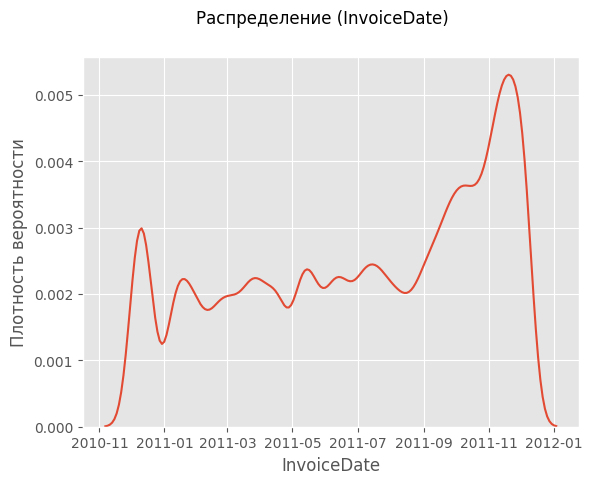

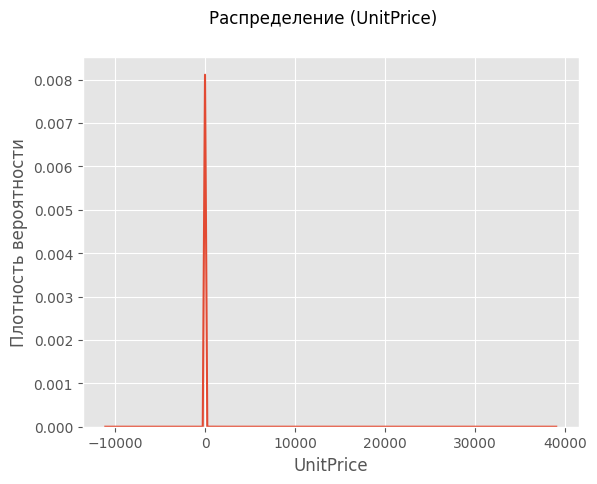

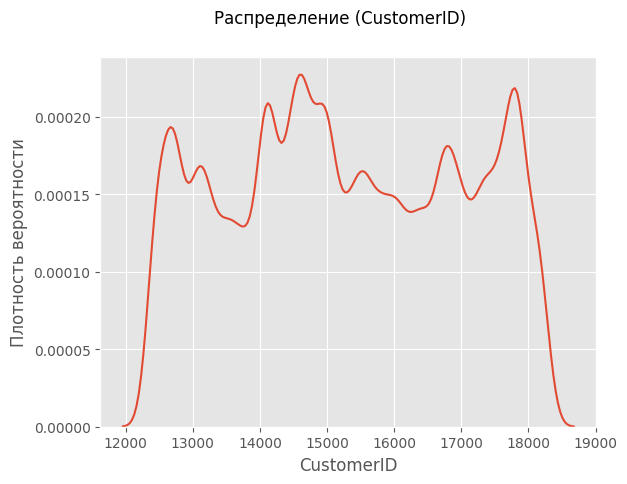



Описание категориальных данных:


,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4221,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478



Графическое представление категориальных данных:


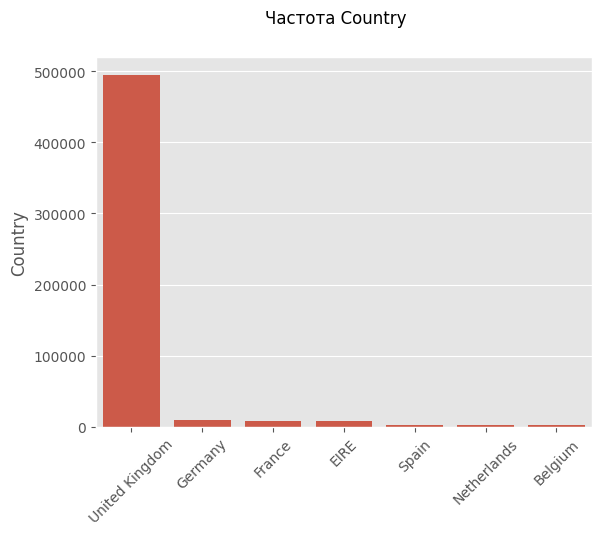



Описание категориальных данных:


,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4221,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478



Вывод уникальных значений по каждому признаку:
InvoiceNo


C558901       1
563934        1
536866        1
C559417       1
559414        1
           ... 
558475      705
580729      721
581492      731
581219      749
573585     1114
Name: InvoiceNo, Length: 25900, dtype: int64

StockCode


72759        1
84971l       1
90183c       1
85034b       1
90184c       1
          ... 
20725     1639
47566     1727
85099B    2159
22423     2203
85123A    2313
Name: StockCode, Length: 4070, dtype: int64

Description


WRAP BLUE RUSSIAN FOLKART                 1
CHRISTMAS CRAFT HEART STOCKING            1
dotcom sales                              1
SET 10 CARDS CHRISTMAS BAUBLE 16954       1
ANT SILVER TURQUOISE BOUDICCA RING        1
                                       ... 
LUNCH BAG RED RETROSPOT                1638
PARTY BUNTING                          1727
JUMBO BAG RED RETROSPOT                2159
REGENCY CAKESTAND 3 TIER               2200
WHITE HANGING HEART T-LIGHT HOLDER     2369
Name: Description, Length: 4221, dtype: int64

Quantity


-80995         1
 1020          1
 234           1
 148           1
-696           1
           ...  
 4         38484
 6         40868
 12        61063
 2         81829
 1        148227
Name: Quantity, Length: 722, dtype: int64

InvoiceDate


2011-03-16 15:58:00       1
2011-04-08 17:08:00       1
2011-08-28 10:54:00       1
2011-04-08 17:07:00       1
2011-08-26 14:20:00       1
                       ... 
2011-06-29 15:58:00     705
2011-12-05 17:24:00     721
2011-12-09 10:03:00     731
2011-12-08 09:28:00     749
2011-10-31 14:41:00    1114
Name: InvoiceDate, Length: 23260, dtype: int64

UnitPrice


2114.00        1
164.46         1
208.12         1
166.92         1
212.04         1
           ...  
0.42       24533
2.95       27768
0.85       28497
1.65       38181
1.25       50496
Name: UnitPrice, Length: 1630, dtype: int64

CustomerID


16995.0       1
18233.0       1
15316.0       1
14679.0       1
14705.0       1
           ... 
14606.0    2782
12748.0    4642
14096.0    5128
14911.0    5903
17841.0    7983
Name: CustomerID, Length: 4372, dtype: int64

Country


Saudi Arabia                10
Bahrain                     19
Czech Republic              30
Brazil                      32
Lithuania                   35
Lebanon                     45
RSA                         58
European Community          61
United Arab Emirates        68
Malta                      127
Greece                     146
Canada                     151
Iceland                    182
Singapore                  229
Hong Kong                  288
USA                        291
Israel                     297
Poland                     341
Japan                      358
Denmark                    389
Austria                    401
Unspecified                446
Sweden                     462
Cyprus                     622
Finland                    695
Channel Islands            758
Italy                      803
Norway                    1086
Australia                 1259
Portugal                  1519
Switzerland               2002
Belgium                   2069
Netherla

In [7]:
check_data(df)

Сегментировать покупки, id клиентов которых неизвестен, не получится. Выбросим их из рассмотрения df. Пропуски в description нам не помешают. Также удалим полные дубликаты, так как это очевидная ошибка.

In [8]:
df = df[(df['CustomerID'].notnull()) & (~df.duplicated())]
df['CustomerID'] = df['CustomerID'].astype(int)

# 2. Сегментирование пользователей

## 2.1 Подготовка перед расчётами

Ещё посмотрим на распределение уникальных покупателей по странам.

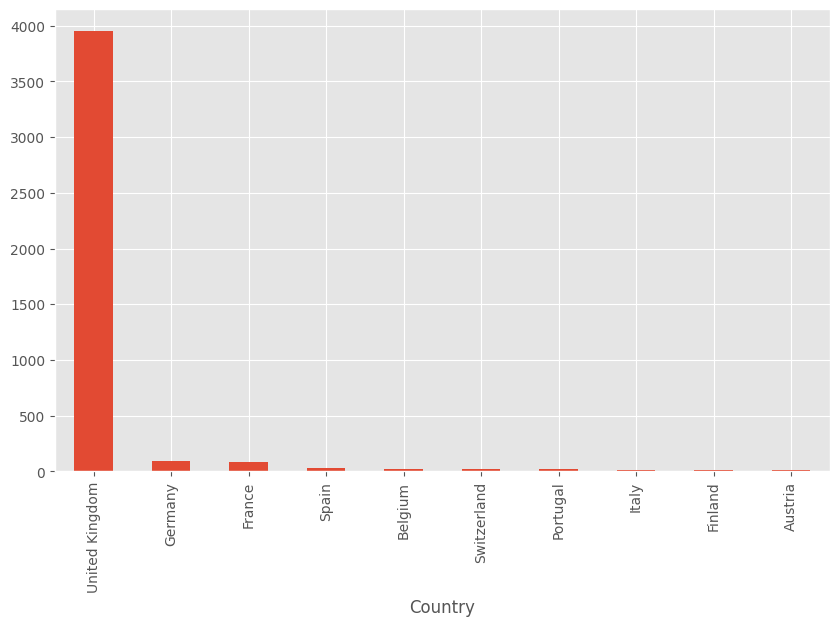

In [9]:
g = (
    df.groupby('Country')['CustomerID']
    .agg('nunique')
    .sort_values(ascending=False)[:10]
    .plot(figsize=(10, 6), kind='bar')
)

g;

Будем работать с Великобританией, так как большинство уникальных пользователей находятся именно там. Остальные пользователи из других стран увидели наш сайт случайно, но они тоже могут приносить нам деньги, поэтому мы переобозначим их страны в одну категорию 'Others'.

In [10]:
df['Country'] = (
    df['Country']
    .apply(lambda x: 'Others' if x != 'United Kingdom' else x)
)

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,401604.0,12.183273,250.283037,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,401604.0,3.474064,69.764035,0.0,1.25,1.95,3.75,38970.0
CustomerID,401604.0,15281.160818,1714.006089,12346.0,13939.00,15145.00,16784.00,18287.0


In [12]:
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Из описания данных видно, что некоторые заказы были отменены, а на некоторые была применена скидка. По сути нам важно, чтобы заказ покупателя не выходил в 0. Если на заказ была применена скидка, то стоимость заказа всё равно какая-то будет, а если покупатель полностью отменил заказ, то этот заказ выбросим.

In [13]:
t = df.copy()

In [14]:
# Колонка с итоговой суммой потраченной при покупке товаров в заказе
t['TotalPrice'] = t['Quantity'] * t['UnitPrice']

In [15]:
# Создадим общую таблицу с суммой всего заказа пользователя. По ней и будем ориентироваться

t = (
    t
    .groupby(['CustomerID', 'InvoiceNo'])
    .agg({'TotalPrice': 'sum',
          'InvoiceDate': 'min',
          'StockCode': lambda x: (x == 'D').any()})
    .reset_index()
)

t.head()

,CustomerID,InvoiceNo,TotalPrice,InvoiceDate,StockCode
0,12346,541431,77183.60,2011-01-18 10:01:00,False
1,12346,C541433,-77183.60,2011-01-18 10:17:00,False
2,12347,537626,711.79,2010-12-07 14:57:00,False
3,12347,542237,475.39,2011-01-26 14:30:00,False
4,12347,549222,636.25,2011-04-07 10:43:00,False


In [16]:
t['InvoiceDate'].min(), t['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [17]:
PRESENT = dt.datetime(2011, 12, 10)  # Самая новая дата

### 2.2 RFM-анализ

In [18]:
rfm = (
    t.groupby('CustomerID')
    .agg({
        'InvoiceDate': lambda x: (PRESENT - x.max()).days,
        'InvoiceNo': lambda x: x.count() - x.str.startswith('C').sum(),
        'TotalPrice': lambda x: x.sum()
    })
)

rfm['InvoiceNo'] = rfm['InvoiceNo'] + t.groupby('CustomerID')['StockCode'].sum()
rfm = rfm.rename(columns={
    'InvoiceNo': 'frequency',
    'InvoiceDate': 'recency',
    'TotalPrice': 'monetary'
    })

In [19]:
rfm.tail()

,recency,frequency,monetary
CustomerID,,,
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,176.60
18283,3,16,2045.53
18287,42,3,1837.28


In [20]:
rfm['monetary'].sum()

8278519.424

Посмотрим на то, как распределены наши характеристики, которые мы построили для сегментации.

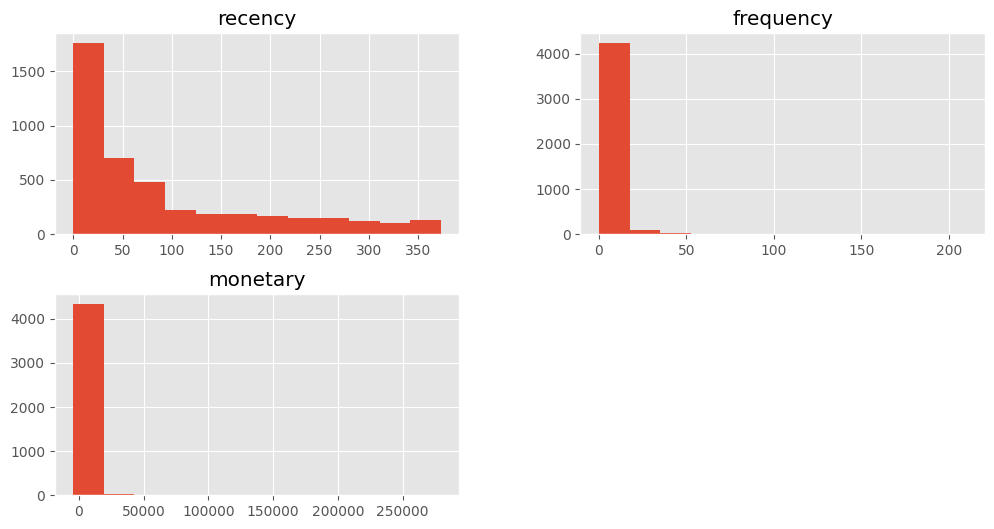

In [21]:
rfm[['recency', 'frequency', 'monetary']].hist(figsize=(12, 6), bins=12);

Прологарифмируем наши характеристики, чтобы визуализация казалась более информативной.

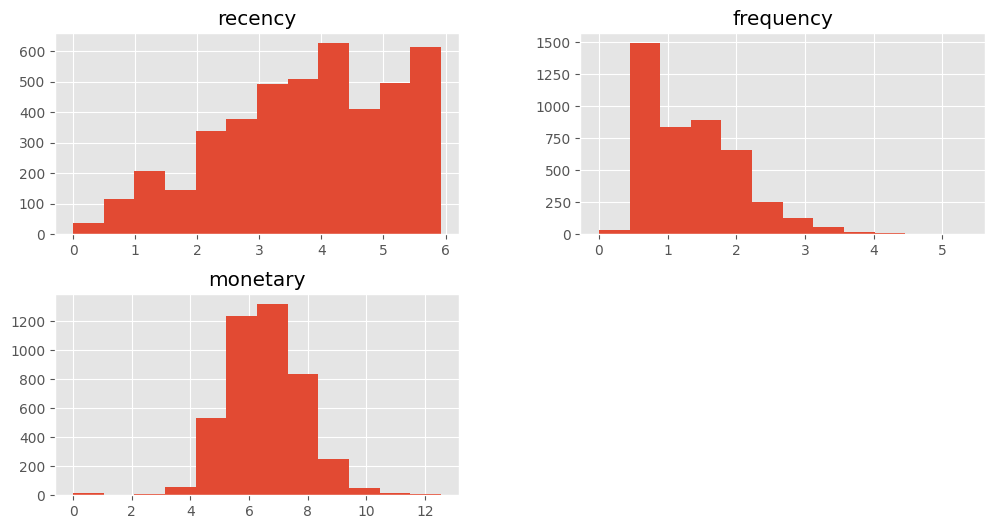

In [22]:
g = (
    rfm[['recency', 'frequency', 'monetary']]
    .apply(lambda x: np.log(x + 1))
    .hist(figsize=(12, 6), bins=12)
)

g;

Для сегментации будут использоваться квартили, поэтому выбросы в данных очищать не будем, так как квартили к выбросам устойчивы. Однако в будущем мы отрисуем картинки, поэтому характеристики мы прологарифмируем в таблице.

In [23]:
rfm[['recency_log', 'frequency_log', 'monetary_log']] = (
    rfm[['recency', 'frequency', 'monetary']]
    .apply(lambda x: np.log(x + 1))
)

In [24]:
rfm['r_quantile'] = pd.qcut(rfm['recency'], 4, ['1', '2', '3', '4'])
rfm['f_quantile'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, ['4', '3', '2', '1'])
rfm['m_quantile'] = pd.qcut(rfm['monetary'], 4, ['4', '3', '2', '1'])

Создадим единую колонку с номерами сегментов.

In [25]:
rfm['rfm_score'] = rfm['r_quantile'].astype(str) + rfm['f_quantile'].astype(str) + rfm['m_quantile'].astype(str)

In [26]:
rfm.head()

,recency,frequency,monetary,recency_log,frequency_log,monetary_log,r_quantile,f_quantile,m_quantile,rfm_score
CustomerID,,,,,,,,,,
12346,325,1,0.00,5.786897,0.693147,0.000000,4,4,4,444
12347,2,7,4310.00,1.098612,2.079442,8.368925,1,1,1,111
12348,75,4,1797.24,4.330733,1.609438,7.494564,3,2,1,321
12349,18,1,1757.55,2.944439,0.693147,7.472245,2,4,1,241
12350,310,1,334.40,5.739793,0.693147,5.815324,4,4,3,443


Больше всего нас интересует категория '111', меньше всего - '444'.

In [27]:
rfm.shape

(4372, 10)

Выберем только самых преданных покупателей.

In [28]:
rfm[rfm['rfm_score'] == '111'].sort_values('monetary', ascending=False).head(10)

,recency,frequency,monetary,recency_log,frequency_log,monetary_log,r_quantile,f_quantile,m_quantile,rfm_score
CustomerID,,,,,,,,,,
14646,1,75,279489.02,0.693147,4.330733,12.540722,1,1,1,111
18102,0,60,256438.49,0.000000,4.110874,12.454648,1,1,1,111
17450,8,47,187322.17,2.197225,3.871201,12.140591,1,1,1,111
14911,1,202,132458.73,0.693147,5.313206,11.794034,1,1,1,111
14156,9,55,113214.59,2.302585,4.025352,11.637049,1,1,1,111
17511,2,31,88125.38,1.098612,3.465736,11.386527,1,1,1,111
16684,4,29,65892.08,1.609438,3.401197,11.095789,1,1,1,111
13694,3,52,62690.54,1.386294,3.970292,11.045982,1,1,1,111
15311,0,91,59284.19,0.000000,4.521789,10.990115,1,1,1,111


Отобразим наиболее значимые по количеству кластеры в пространстве.

In [29]:
rfm['rfm_score'].value_counts().sort_values(ascending=False)[:10]

111    482
444    321
211    229
434    180
222    178
443    164
322    153
433    141
344    141
122    130
Name: rfm_score, dtype: int64

In [30]:
clusters = rfm['rfm_score'].value_counts()
big_clusters = clusters[clusters > 100].index.values
big_clusters

array(['111', '444', '211', '434', '222', '443', '322', '433', '344',
       '122', '333', '343', '112'], dtype=object)

In [31]:
import plotly.express as ex

ex.scatter_3d(
    rfm[rfm['rfm_score'].isin(big_clusters)],
    x='recency_log',
    y='frequency_log',
    z='monetary_log',
    color='rfm_score'
)

Из этих кластеров рассмотрю на распределении те, где кластеры имеют хорошую или выше среднего оценку rfm-score. Рассмотрю их по проскостям.

In [32]:
significant_clusters = ['111', '122', '211', '222', '112']

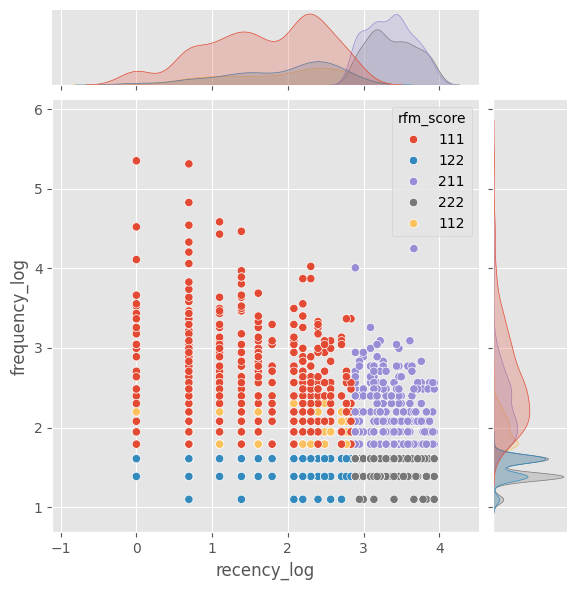

In [33]:
g = sns.jointplot(
    rfm[rfm['rfm_score'].isin(significant_clusters)],
    x='recency_log',
    y='frequency_log',
    hue='rfm_score'
)

g;

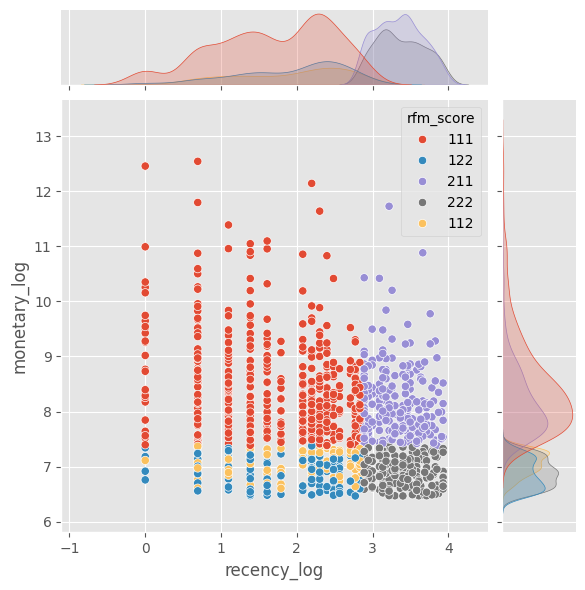

In [34]:
g = sns.jointplot(
    rfm[rfm['rfm_score'].isin(significant_clusters)],
    x='recency_log',
    y='monetary_log',
    hue='rfm_score'
)

g;

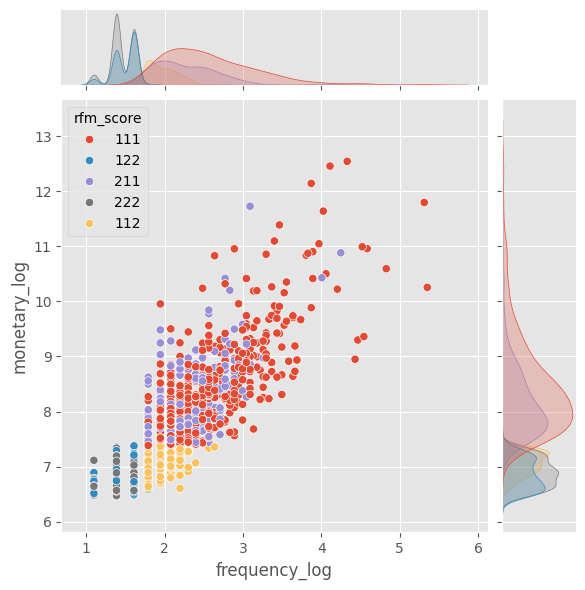

In [35]:
g = sns.jointplot(
    rfm[rfm['rfm_score'].isin(significant_clusters)],
    x='frequency_log',
    y='monetary_log',
    hue='rfm_score'
)

g;

# 3. Продуктовые метрики

## 3.1 Подготовка перед расчётами

### 3.1.1 Таблица с уникальными пользователями

В реальной жизни такая таблица обычно имеется сразу и можно ей пользоваться.

In [37]:
users = df.groupby(['CustomerID'])['InvoiceDate'].min().reset_index()
users.columns = ['CustomerID', 'reg_date']
users.head()

,CustomerID,reg_date
0,12346,2011-01-18 10:01:00
1,12347,2010-12-07 14:57:00
2,12348,2010-12-16 19:09:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


In [38]:
users['reg_month'] = users['reg_date'].values.astype('datetime64[M]')
users.head()

,CustomerID,reg_date,reg_month
0,12346,2011-01-18 10:01:00,2011-01-01
1,12347,2010-12-07 14:57:00,2010-12-01
2,12348,2010-12-16 19:09:00,2010-12-01
3,12349,2011-11-21 09:51:00,2011-11-01
4,12350,2011-02-02 16:01:00,2011-02-01


Сгенерируем таблицу, где на каждого юзера будет каждый месяц.

In [39]:
min_month = df['InvoiceDate'].values.astype('datetime64[M]').min()
max_month = df['InvoiceDate'].values.astype('datetime64[M]').max()
(min_month, max_month)

(numpy.datetime64('2010-12'), numpy.datetime64('2011-12'))

In [40]:
dr = pd.DataFrame(pd.date_range(min_month, max_month, freq='MS'))
dr.head()

,0
0,2010-12-01
1,2011-01-01
2,2011-02-01
3,2011-03-01
4,2011-04-01


In [41]:
dr.columns = ['month']

Теперь надо сделать кросcджоин. Должно получиться

In [42]:
len(users) * len(dr)

56836

строк. В пандас кросcджоин делается так:

In [43]:
dr['key'] = 1
users['key'] = 1

In [44]:
report = dr.merge(users, on='key')
report.shape

(56836, 5)

Как и ожидали, но у нас есть пользователи, которые пришли после минимальной даты (2010-12) и глупо хранить по ним строчки за тот период, пока их с нами не было.

In [45]:
report = report[report['month'] >= report['reg_month']]

In [46]:
len(report)

37436

Глянем на отдельного пользователя.

In [47]:
report[report['CustomerID'] == 12346]

,month,key,CustomerID,reg_date,reg_month
4372,2011-01-01,1,12346,2011-01-18 10:01:00,2011-01-01
8744,2011-02-01,1,12346,2011-01-18 10:01:00,2011-01-01
13116,2011-03-01,1,12346,2011-01-18 10:01:00,2011-01-01
17488,2011-04-01,1,12346,2011-01-18 10:01:00,2011-01-01
21860,2011-05-01,1,12346,2011-01-18 10:01:00,2011-01-01
26232,2011-06-01,1,12346,2011-01-18 10:01:00,2011-01-01
30604,2011-07-01,1,12346,2011-01-18 10:01:00,2011-01-01
34976,2011-08-01,1,12346,2011-01-18 10:01:00,2011-01-01
39348,2011-09-01,1,12346,2011-01-18 10:01:00,2011-01-01
43720,2011-10-01,1,12346,2011-01-18 10:01:00,2011-01-01


Теперь можно джойнить инфу по продажам.

### 3.1.2 Группировка данных по продажам

Посчитаем суммарные продажи на каждый месяц.

In [48]:
df['month'] = df['InvoiceDate'].values.astype('datetime64[M]')

In [49]:
df['revenue'] = df['UnitPrice'] * df['Quantity']

In [50]:
sales_month = (
    df.groupby(['CustomerID', 'month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
sales_month.head()

,CustomerID,month,revenue
0,12346,2011-01-01,0.00
1,12347,2010-12-01,711.79
2,12347,2011-01-01,475.39
3,12347,2011-04-01,636.25
4,12347,2011-06-01,382.52


Обязательно проверим контрольную сумму.

In [51]:
round(df['revenue'].sum(), 4), round(sales_month['revenue'].sum(), 4)

(8278519.424, 8278519.424)

### 3.1.3 Объединение таблиц

In [52]:
report = report.merge(sales_month, how='left', on=['CustomerID', 'month'])
report = report.drop(columns=['key'])
report['revenue'] = report['revenue'].fillna(0)

In [53]:
report.head()

,month,CustomerID,reg_date,reg_month,revenue
0,2010-12-01,12347,2010-12-07 14:57:00,2010-12-01,711.79
1,2010-12-01,12348,2010-12-16 19:09:00,2010-12-01,892.80
2,2010-12-01,12370,2010-12-14 12:58:00,2010-12-01,1864.27
3,2010-12-01,12377,2010-12-20 09:37:00,2010-12-01,1001.52
4,2010-12-01,12383,2010-12-22 14:28:00,2010-12-01,600.72


Добавим флаг юзера, нового юзера, и активного юзера.

In [54]:
report['user'] = 1
report['new_user'] = (report['reg_month'] == report['month']) * 1
report['active'] = (report['revenue'] > 0) * 1
report.head()

,month,CustomerID,reg_date,reg_month,revenue,user,new_user,active
0,2010-12-01,12347,2010-12-07 14:57:00,2010-12-01,711.79,1,1,1
1,2010-12-01,12348,2010-12-16 19:09:00,2010-12-01,892.80,1,1,1
2,2010-12-01,12370,2010-12-14 12:58:00,2010-12-01,1864.27,1,1,1
3,2010-12-01,12377,2010-12-20 09:37:00,2010-12-01,1001.52,1,1,1
4,2010-12-01,12383,2010-12-22 14:28:00,2010-12-01,600.72,1,1,1


## 3.2 Расчёт метрик

In [55]:
t = (report
     .groupby('month')[['revenue', 'user', 'new_user', 'active']]
     .agg('sum')
)
t.head()

,revenue,user,new_user,active
month,,,,
2010-12-01,552372.860,948,948,881
2011-01-01,473731.900,1369,421,736
2011-02-01,435534.070,1749,380,753
2011-03-01,578576.210,2189,440,968
2011-04-01,425222.671,2488,299,850


Количество новых пользователей соответствует количеству уникальных пользователей.

In [56]:
t['new_user'].sum(), len(df['CustomerID'].unique())

(4372, 4372)

Рассчитаем метрики.

In [57]:
# коэффициент активации
t['activation_rate'] = round(t['new_user'] / t['user'], 4)
# коэффициент удержания, доли
t['retention_rate'] = round((t['active'] - t['new_user']) / (t['user'] - t['new_user']), 4)
t.loc[t['retention_rate'].abs() == float('inf'), 'retention_rate'] = None
# cредний доход с активного пользователя за месяц
t['arpau'] = round(t['revenue'] / t['active'], 2)
# средний доход с нового пользователя за месяц
t['arpn'] = round(t['revenue'] / t['new_user'], 2)
# коэффициент роста пользовательской базы за месяц, доли
t['agr'] = round((t['user'] / (t['user'] - t['new_user'])) - 1, 4)
t.loc[t['agr'] == float('inf'), 'agr'] = None

In [58]:
t.head(12)

,revenue,user,new_user,active,activation_rate,retention_rate,arpau,arpn,agr
month,,,,,,,,,
2010-12-01,552372.860,948,948,881,1.0000,NaN,626.98,582.67,NaN
2011-01-01,473731.900,1369,421,736,0.3075,0.3323,643.66,1125.25,0.4441
2011-02-01,435534.070,1749,380,753,0.2173,0.2725,578.40,1146.14,0.2776
2011-03-01,578576.210,2189,440,968,0.2010,0.3019,597.70,1314.95,0.2516
2011-04-01,425222.671,2488,299,850,0.1202,0.2517,500.26,1422.15,0.1366
2011-05-01,647011.670,2767,279,1052,0.1008,0.3107,615.03,2319.04,0.1121
2011-06-01,606862.520,3002,235,986,0.0783,0.2714,615.48,2582.39,0.0849
2011-07-01,573112.321,3193,191,943,0.0598,0.2505,607.75,3000.59,0.0636
2011-08-01,615078.090,3360,167,930,0.0497,0.2390,661.37,3683.10,0.0523


Визуализация метрик

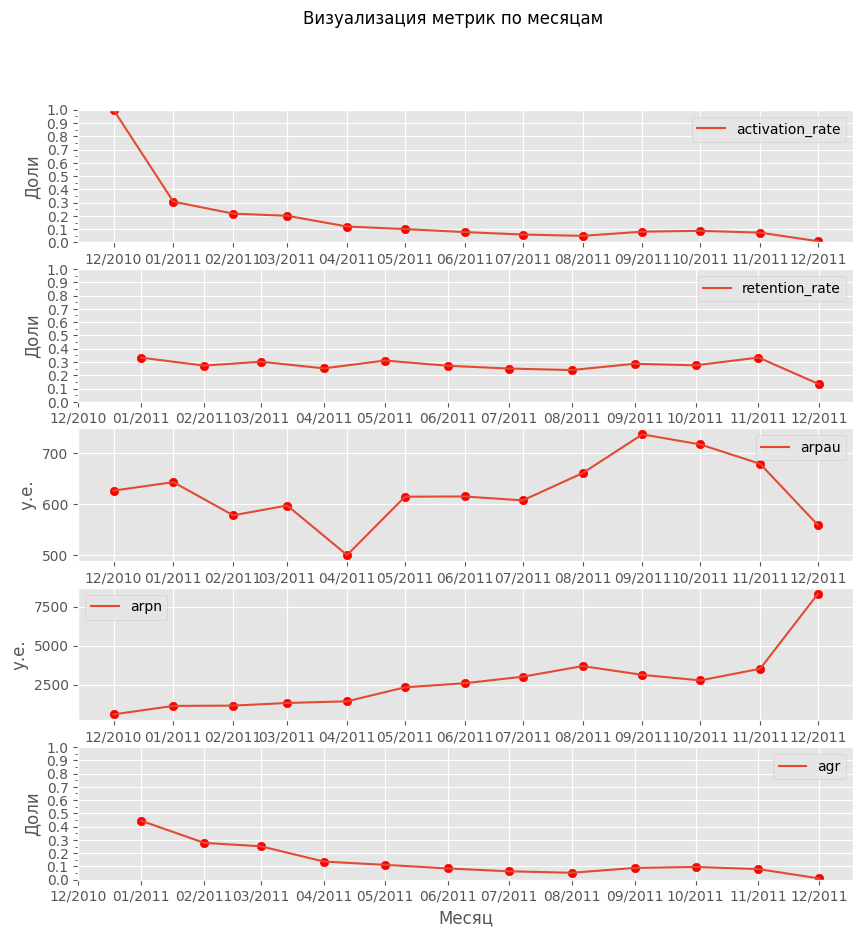

In [59]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

ax[0].plot(t.index, t['activation_rate'], label='activation_rate')
ax[0].scatter(t.index, t['activation_rate'], color='red')
ax[0].set_xlabel('Месяц')
ax[0].set_ylabel('Доли')
ax[0].set_xticks(t.index.values)
ax[0].set_xticklabels(pd.to_datetime(t.index).strftime('%m/%Y'))
ax[0].set_ylim((0, 1))
ax[0].yaxis.set_major_locator(MultipleLocator(0.1))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].legend()

ax[1].plot(t.index, t['retention_rate'], label='retention_rate')
ax[1].scatter(t.index, t['retention_rate'], color='red')
ax[1].set_xlabel('Месяц')
ax[1].set_ylabel('Доли')
ax[1].set_xticks(t.index.values)
ax[1].set_xticklabels(pd.to_datetime(t.index).strftime('%m/%Y'))
ax[1].set_ylim((0, 1))
ax[1].yaxis.set_major_locator(MultipleLocator(0.1))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].legend()

ax[2].plot(t.index, t['arpau'], label='arpau')
ax[2].scatter(t.index, t['arpau'], color='red')
ax[2].set_xlabel('Месяц')
ax[2].set_ylabel('у.е.')
ax[2].set_xticks(t.index.values)
ax[2].set_xticklabels(pd.to_datetime(t.index).strftime('%m/%Y'))
ax[2].legend()

ax[3].plot(t.index, t['arpn'], label='arpn')
ax[3].scatter(t.index, t['arpn'], color='red')
ax[3].set_xlabel('Месяц')
ax[3].set_ylabel('у.е.')
ax[3].set_xticks(t.index.values)
ax[3].set_xticklabels(pd.to_datetime(t.index).strftime('%m/%Y'))
ax[3].legend()

ax[4].plot(t.index, t['agr'], label='agr')
ax[4].scatter(t.index, t['agr'], color='red')
ax[4].set_xlabel('Месяц')
ax[4].set_ylabel('Доли')
ax[4].set_xticks(t.index.values)
ax[4].set_xticklabels(pd.to_datetime(t.index).strftime('%m/%Y'))
ax[4].set_ylim((0, 1))
ax[4].yaxis.set_major_locator(MultipleLocator(0.1))
ax[4].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[4].legend()

plt.suptitle('Визуализация метрик по месяцам');

KeyError: 'Month'

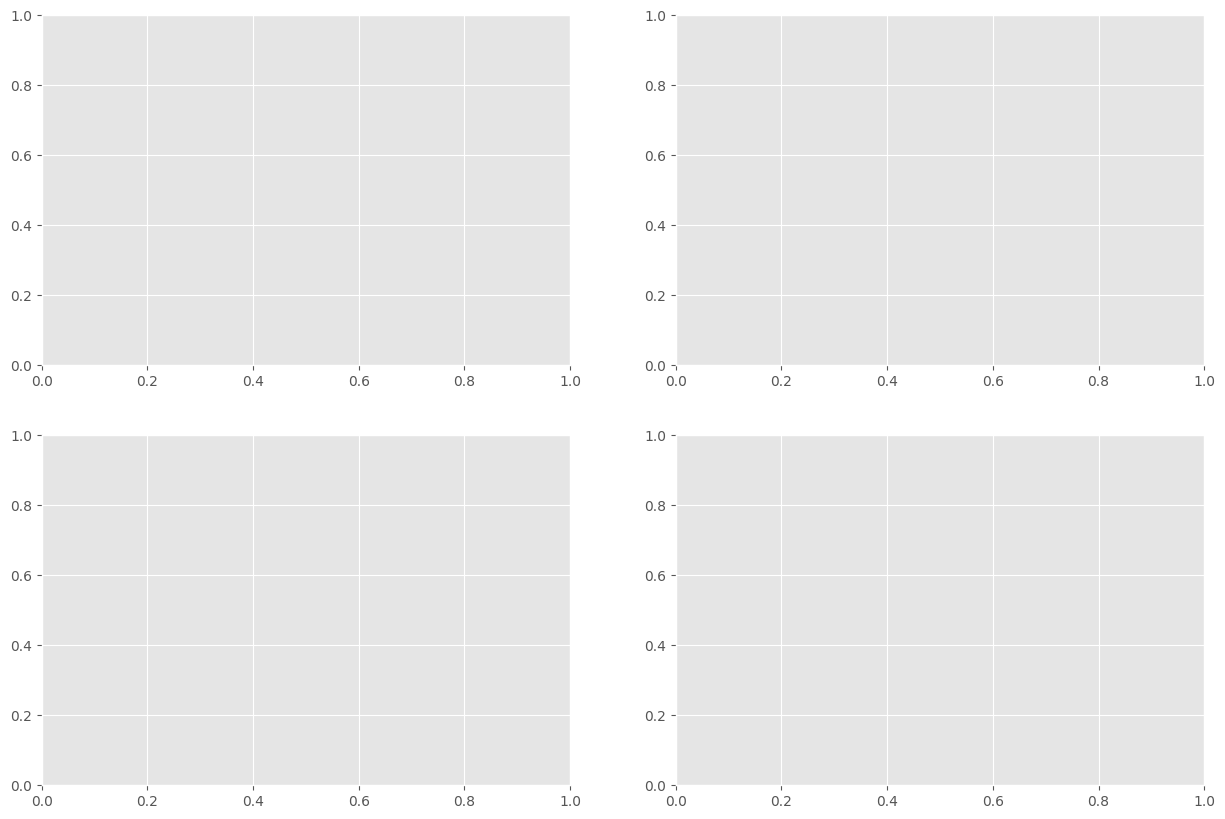

In [60]:
index = 0
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

times = 'Month', 'Day', 'Hour', 'Weekday'
bins = 12, 31, 24, 7

for i in range(2):
  for j in range(2):
    ax[i, j].hist(report[times[index]], bins=bins[index], edgecolor='black')
    ax[i, j].set_title('Гистограмма {}'.format(times[index]))
    index += 1

fig.subplots_adjust(hspace=1);

Построю тепловую карту для пользователей и гляну на их возвращаемость на сайт

In [ ]:
# df_day = (
#     df.groupby()
# )
# kagort_year

# retention = (
#     kagort_year.pivot_table(
#         index='reg_month',
#         columns='month',
#         values='CustomerID',
#         aggfunc='nunique'
#     )
# )

# sns.heatmap(
#     retention,
#     annot=True,
#     fmt='.0f',
#     linewidths=1,
#     linecolor='black',
#     cmap='YlGnBu'
# );